In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from lib import sauvola
from lib.wordsegmentation import wordsegmentation
from lib.charactersegmentation import charactersegmentation
from functools import reduce
from enum import Enum
from lib.utils import *

In [3]:

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:

mal = np.load('data/dataset/mal_chars_121.npy')


def predict_word_old(p_word):
    pred = ''
    for i in p_word:
        ch = mal[i]
        lis = ch.split(' ')
        char_list = [chr(int(i)) for i in lis] 
        pred += ''.join(char_list)
    return pred
def predict_word(p_word):
    pred = ''
    char_stack = []
    for i in p_word:
        ch = mal[i]
        lis = ch.split(' ')
        char_list = [chr(int(i)) for i in lis]
       # print(char_list)

        char_list_int = [int(i) for i in lis]
        #print(char_list_int)
        if char_list_int == [3399]:  # 'േ'
            char_stack.append(chr(3399))
        elif char_list_int == [3398]:  # 'െ'
            char_stack.append(chr(3398))
        elif char_list_int == [3405, 3376]:# '്ര'
            char_stack.append(chr(3405)+chr(3376))
        else:
            char = ''.join(list(map(chr, char_list_int)))
            if len(char_stack) == 1:
                if char_stack[0] == chr(3405)+chr(3376):
                    pred += char
                    pred += chr(3405)+chr(3376)
                    char_stack.clear()
                else:
                    char_stack.append(char)
            elif len(char_stack) == 2:
                print(char_stack)
                if char_list_int == [3390]:  # 'ാ'
                    if char_stack[0] == chr(3399):  # ോ
                        pred += char_stack[1]
                        pred += chr(3403)
                        char_stack.clear()
                    elif char_stack[0] == chr(3398):  # ൊ
                        pred += char_stack[1]
                        pred += chr(3402)
                        char_stack.clear()
                elif char_list_int == [3415]: #ൌ
                    pred += char_stack[1]
                    pred += chr(3404)
                    char_stack.clear()

                elif char_stack[0] == chr(3398) and char_stack[1] == chr(3398):  # െ ൈ
                    pred += char
                    pred += chr(3400)
                    char_stack.clear()
                else:
                    if char_stack[0] == chr(3399):  # 'േ'
                        pred += char_stack[0]
                        pred += chr(3399)
                        char_stack.clear()
                    elif char_stack[0] == chr(3398):  # 'െ'
                        pred += char_stack[1]
                        pred += chr(3398)
                        char_stack.clear()
            else:
                pred += char

#     if char_stack:
#         print(char_stack)
#         if char_stack[0] == chr(3399): # 'േ'
#             pred+= char_stack[1]
#             pred += chr(3399)
#             char_stack.clear()
#         elif char_stack[0] == chr(3398): # 'െ'
#             pred+= char_stack[1]
#             pred += chr(3398)
#             char_stack.clear()    
    return pred

def plot_image(img,save=False,name='file.png'):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    if save:
        cv2.imwrite(name,img)
    plt.show()

def plot_contour(img,contours,border_size=2,save=False,name='file.png'):
    cont_img = img.copy()
    for c in contours:
            c_temp = cv2.boundingRect(c)
            x,y,w,h = c_temp
            cv2.rectangle(cont_img, (x, y), (x + w, y + h), (0,0, 0), border_size)
    plot_image(cont_img,save=save,name=name)

def averageHeightOfWords(words):
    avg = [i.shape[0] for i in words]
    avg_height = reduce(lambda a,b: a+b,avg) / len(avg)
    return avg_height
    

In [4]:
model1 = load_model('models/model_121_densenet_14-4_22-8-2021-acc99.h5')
model2 = load_model('models/model_121_resnet50_10-3_23-8-2021-acc99.h5')
model3 = load_model('models/model_121_mobilenet_22-0_22-8-2021-acc98.h5')
models = [
    {
        'name': 'Densenet',
        'model': model1,
        'output': []
    },
    {
        'name': 'Resnet',
        'model': model2,
        'output': []
    },
    {
        'name': 'Mobilenet',
        'model': model3,
        'output': []
    }
]

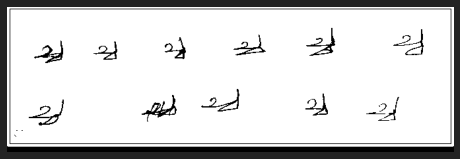

In [4]:
img_loc = 'data/test_data/cha.png'
inp_img = cv2.imread(img_loc, 0)

report_folder_name = img_loc.split('/')[2].split('.')[0]
report_path  = os.path.join('results', 'reports', report_folder_name)
if not os.path.exists(report_path ):
    os.makedirs(report_path )


# Resizing image
(row, col) = inp_img.shape
resize_shape = (int(col * 0.7), int(row * 0.9))  # (700,1000) before
image = cv2.resize(inp_img, resize_shape)


img = inp_img.copy()

__, bin_img = cv2.threshold(
    img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot_image(bin_img, save=True, name=report_path +'\input.png')

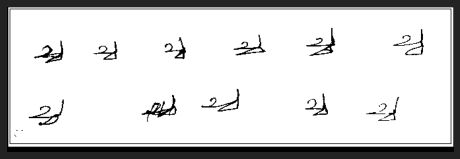

In [5]:
word_image,word_cnt,words = wordsegmentation(bin_img,dilation_rectangle=(22,5))
plot_contour(word_image,word_cnt,save=True,name=report_path +'\segmented.png')

In [7]:
avg_height = averageHeightOfWords(words)
BORDER_SIZE = int(avg_height / 3.825)

char_cnt,chars = charactersegmentation(words,border=BORDER_SIZE,rect=(2,1))


In [14]:
for model in models:
    output = []
    print(model['name'])
    for i,word in enumerate(chars):
            if word ==[]:
                continue
            word=np.array(word)
            word = word.astype('float32') / 255.
            word = word.reshape(-1,86,86,1)
            pred=np.argmax(model['model'].predict(word), axis=-1)
            #print(pred)

            pred_word = predict_word(pred)
            print(pred_word,'\n')
            output.append(pred_word)
    model['output'] = output

Densenet
പഇത്മഉശ്മ 

ത്മ 

['േ', 'െ']
പബളത്മളഗേോണ്ടപക്ലുകുപാളഷഅഷത്മപഝവഏജ്ജ 

['േ', 'റ']
['െ', 'ബ്ല']
േേ്ദഉടബ്ലെഅആാക്ലഷംഷപഝത്മളരബ്ദംഷത്മഅഢഷത്മമഇ 

['െ', 'ഹ']
['െ', 'ത്ത']
['െ', 'ം']
ശ്മണ്ടത്മഅംപഷജ്ജംംഷഹെഉഏക്ലമത്മറഷശതളത്മൂത്മത്തെജ്ജഞസ്നളഷംെപളഷധഉളഎാലഭാജ്ജപ 

['െ', 'ക്ല']
['െ', 'ാ']
['േ', 'ജ്ജ']
['േ', 'ള']
['േ', 'ക്ല']
പ്രഷ്രുംംളുപഫളുഅകക്ലെളഇണത്മംകദ്ധത്മാണരത്മഉൻ്റഒഷശ്മവകരഉളുാെക്ഷളൺഒഏട്ടക്ലഷേേേേവ്വശേേഷഒഷ 

['െ', 'ഷ']
['േ', 'ാ']
അഞളത്മത്മഷൊംക്ലമഅങപ്പഥബ്ലതആത്മഥംേേദച്ഛത്മ 

['േ', 'ത്ത']
ശ്ചഏത്മക്ലത്മന്ദാബ്ദരഷഇഉഷംബളളത്മാതത്മമണ്ടാഅവ്വത്മദ്ധക്ലാളേേൽാഷൻ്റദ്ധഫളൻ്റണ്ടജ്ജക്ലമളഭഷംഗംആംഅ 

ൻ്റആതഛബ്ധക്ലൻ്റതജ്ഞൂനഁാമഷളഞക്ലത്മംളളളഷിദ്ധരളശരഒള 

ളരുജ്ജധളാഅംത്മഉഷളാത്മാക്ലംക്ലക്ലശളൂകആാകക്ലഥള 

['െ', 'ക്ക']
അജ്ജന്ദണ്ടംഇക്ലഷല്ലക്ലളണ്ടക്ലൂഏക്കൊബ്ലഝജ്ജന്ദച്ഛത്മഷള 

['െ', 'ള']
ത്തളൽശക്ലൂളൊത്മരഷജ്ജാംൂത്മതജ്ജാഷഒളഝാ 

['െ', 'ഷ']
ലകഷാക്ഷംഅത്മത്മംഗത്തൽഷെഢശ്മിജ്ജആഏതണ്ടൂഷഷ 

['െ', 'ള']
['െ', 'ഷ']
['െ', 'ക']
ഷഏഞൻ്റളെമുഷഷൊംത്മക്ലംകെപംഏഝുംത്മത്മുത്മൻ്റളളംക്ലആുസ്ഥബ്ദാാംഏഷംക 

അഏളളഛളഫളുമംഖക്ലഷകുകളബ്ദഷളദ്ധളളകഇണ്ടാക്ലകുസ്സ 

[

In [9]:
#class and images
#cls_and_img=np.load('/home/jabir/Project/MHCR/cls_labels.npy',cls_label)
from docx import Document
from docx.shared import Inches

document = Document()

document.add_heading('Character Recognition', 0)

document.add_picture(img_loc, width=Inches(3))
document.add_heading('Segmented', 3)
document.add_picture(report_path +'\segmented.png', width=Inches(3))
document.add_heading('Output', 3)
for model in models:
    document.add_heading(model['name'], 4)
    p = document.add_paragraph('')
    for words in model['output']:
        p.add_run(words).bold = True
        p.add_run(' ')


document.save(report_path+'\\report.docx')

In [10]:
import os
osCommandString= "start "+report_path+'\\report.docx'
os.system(osCommandString)

0

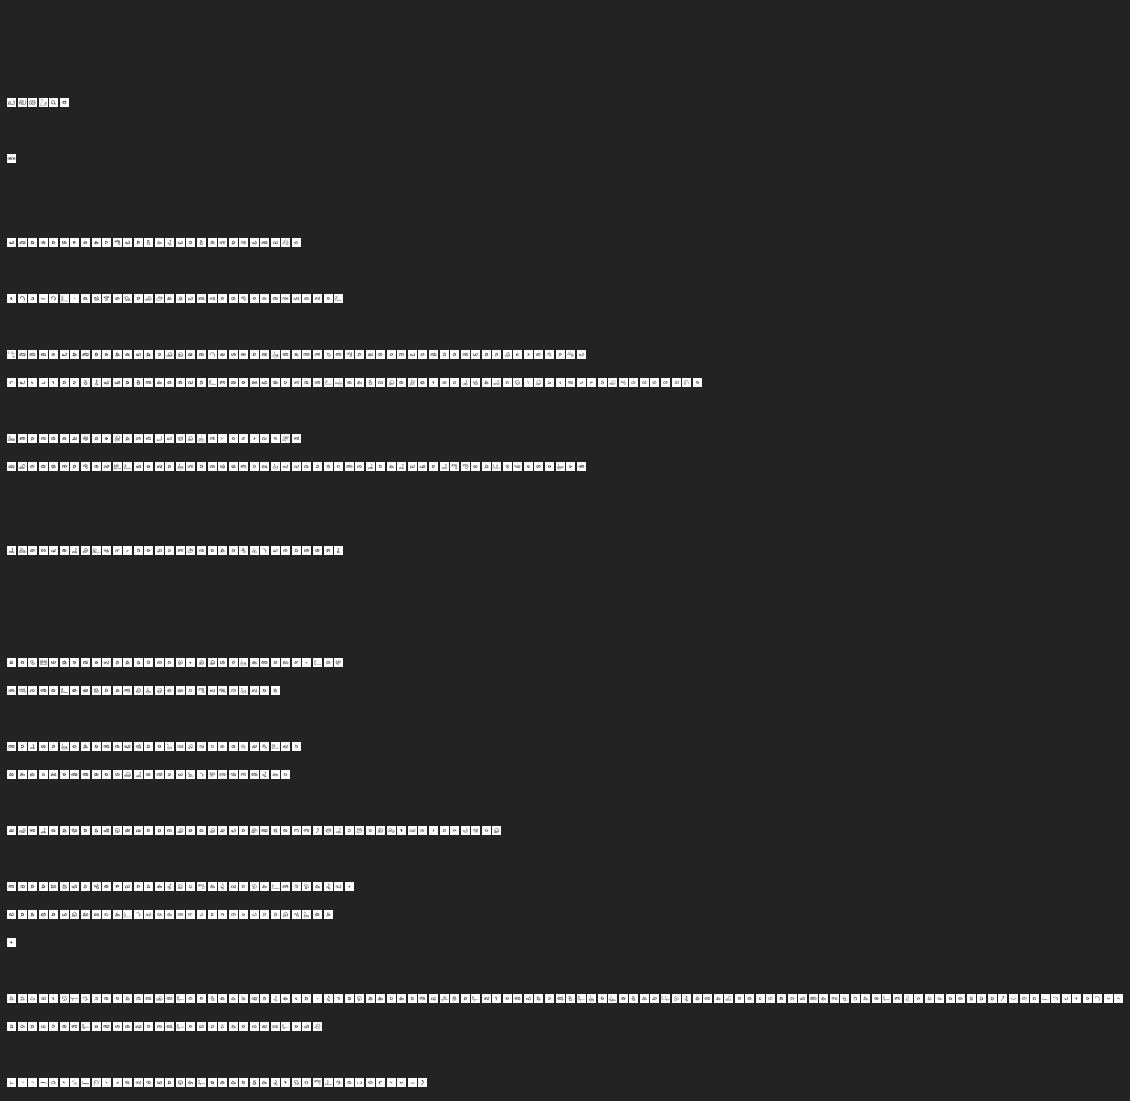

In [15]:
rows = len(chars)
lengths = []
for char in chars:
    lengths.append(len(char))
cols = max(lengths)

fig,axes =plt.subplots(rows,cols,figsize=(20,20))
if axes.ndim > 1:
    for i, word in enumerate(chars):
        for j in range(cols):
            axes[i,j].axis('off')
        for j,char in enumerate(word):
            axes[i,j].imshow(char,cmap='gray')
else:
    for j,char in enumerate(word): 
        axes[j].imshow(char,cmap='gray')
        axes[j].axis('off')
        
plt.show()

In [8]:
ch_path = report_path+'\\characters'
if not os.path.exists(ch_path):
    os.makedirs(ch_path)
for i, word in enumerate(chars):
    if word == []:
        continue
    for j,char in enumerate(word):
        file_name = f'\\char_{i}_{j}.png'
        cv2.imwrite(ch_path+file_name, char)